# Fitting $\beta$ and $\gamma$ Parameters from Data

**Author: Veronica Scerra**  
**Last Updated: 2025-10-14**

**Purpose:**
Estimate Beta and gamma from synthetic data

**Inputs & Dependencies:**
- Code: `src/epimodels/sir.py`, `src/epimodels/fitting.py`
- Libraries: `numpy`, `matplotlib`, `pandas`  
- No external data required.

**Outputs:**
- Paramter estimates ($\beta$, $\gamma$) from data
- Visualization of S, I, R over time with estimated parameters

**Context:**
Third notebook in the **SIR Model Project**, serving as a means for estimating parameter values from data (synthetic at first, extending to real data)

### Import paths and dependencies

In [1]:
import sys, os, numpy as np, pandas as pd, matplotlib.pyplot as plt
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

from epimodels.sir import SIRModel
from epimodels.fitting import fit_beta_gamma


### Create some synthetic "observed" data 

In [2]:
# Ground-truth params
N = 10000
beta_true = 0.28
gamma_true = 0.12
I0, R0_init = 12, 0

# time grid
T = 140
t = np.arange(0, T+1, 1.0) #daily

# simulate truth
truth = SIRModel(N, beta_true, gamma_true).simulate(t=t, I0=I0, R0_init=R0_init)
I_true = truth["I"]
inc_true = truth["incidence"]

# choose an observable to "measure" 
observable = "incidence" # or "I" 

# add some noise to mimic measurement error
rng = np.random.default_rng(7)
if observable == "incidence":
    # Poisson-like noise (counts): clip to non-negative
    y_obs = np.maximum(0.0, inc_true + rng.normal(0, 0.05 * np.max(inc_true), size=inc_true.size))
else:
    # prevalence-like noise
    y_obs = np.maximum(0.0, I_true + rng.normal(0, 0.03 * np.max(I_true), size=I_true.size))



### Fit $\beta$, $\gamma$

In [3]:
result = fit_beta_gamma(
    t=t,
    y_obs=y_obs,
    N=N,
    I0=I0,
    R0_init=R0_init,
    observable=observable,
    beta_bounds=(0.05, 0.6),
    gamma_bounds=(0.05, 0.5),
    grid_size=(20, 20),
    weights=None,          # e.g., np.linspace(0.5, 1.5, len(t)) to upweight later data
    refine=True,
    init_step=(0.02, 0.02),
    random_restarts=3
)

result

{'beta': 0.28157894736842104,
 'gamma': 0.12105263157894737,
 'R0': 2.326086956521739,
 'loss': 137.67202870463905,
 'scale': 0.9865348633702657,
 'y_fit': array([0.00000000e+00, 3.61020489e+00, 4.23527357e+00, 4.96761985e+00,
        5.82529891e+00, 6.82927058e+00, 8.00381589e+00, 9.37699382e+00,
        1.09811339e+01, 1.28533557e+01, 1.50361005e+01, 1.75776509e+01,
        2.05326032e+01, 2.39622410e+01, 2.79347410e+01, 3.25251149e+01,
        3.78147634e+01, 4.38904884e+01, 5.08427707e+01, 5.87630928e+01,
        6.77400666e+01, 7.78541243e+01, 8.91705741e+01, 1.01730915e+02,
        1.15542488e+02, 1.30566799e+02, 1.46707257e+02, 1.63797490e+02,
        1.81591941e+02, 1.99760823e+02, 2.17891734e+02, 2.35499989e+02,
        2.52048970e+02, 2.66980404e+02, 2.79752664e+02, 2.89883209e+02,
        2.96989768e+02, 3.00824245e+02, 3.01294041e+02, 2.98467432e+02,
        2.92562423e+02, 2.83921393e+02, 2.72976049e+02, 2.60208285e+02,
        2.46112366e+02, 2.31162625e+02, 2.15789190e+0

### Plot Observed vs. Fitted Data

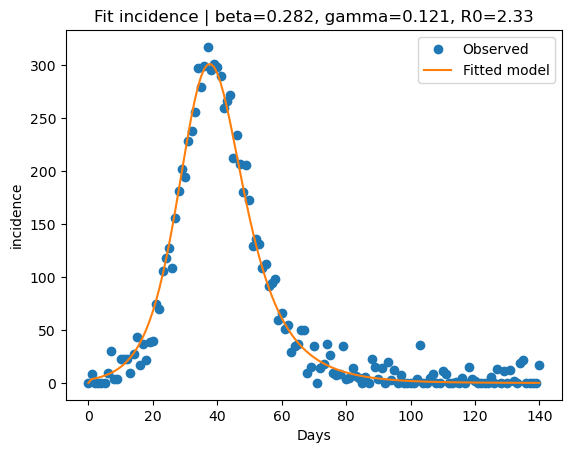

In [4]:
y_fit = result["y_fit"]
plt.figure()
plt.plot(t, y_obs, label="Observed", marker='o', linestyle='')
plt.plot(t, y_fit, label="Fitted model")
plt.xlabel("Days"); plt.ylabel(observable)
plt.title(f"Fit {observable} | beta={result['beta']:.3f}, gamma={result['gamma']:.3f}, R0={result['R0']:.2f}")
plt.legend(); plt.show()

### Inspect full trajectories (S, I, R)

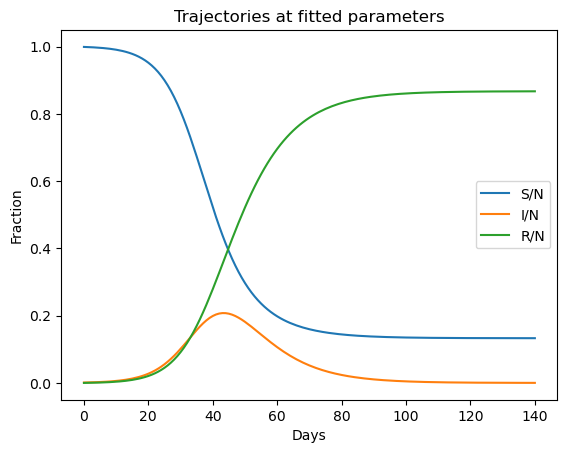

In [5]:
sim = result['sim']
plt.figure()
plt.plot(t, sim["S"]/N, label="S/N")
plt.plot(t, sim["I"]/N, label="I/N")
plt.plot(t, sim["R"]/N, label="R/N")
plt.xlabel("Days"); plt.ylabel("Fraction")
plt.title("Trajectories at fitted parameters")
plt.legend(); plt.show()

###

### Tips for using practically

- Bounds matter: if you know the infectious period ~ 1/$\gamma$ (say 7-14 days), set `gamma_bounds=(1/20, 1/4)` to target plausible values and speed things up.
- Choose the right observable.
    - If you have daily case counts, use `observable="incidence"`.
    - If you have current active infections, use `observable="I"`.
- Weighting: Early data can be noisy; try `weights` to emphasize mid-curve or peak (eg. bell-shaped weight)
- Identifiability: With short or heavily noisy series, $\beta$ and $\gamma$ can be weakly identified but *R0* = $\beta$/$\gamma$ is often more stable. Report both parameters and *R0*
